# NLP: FlipItNews

### Context:

The Gurugram-based company ‘FlipItNews’ aims to revolutionize the way Indians perceive finance, business, and capital market investment, by giving it a boost through artificial intelligence (AI) and machine learning (ML). They’re on a mission to reinvent financial literacy for Indians, where financial awareness is driven by smart information discovery and engagement with peers. Through their smart content discovery and contextual engagement, the company is simplifying business, finance, and investment for millennials and first-time investors


### Objective:

The goal of this project is to use a bunch of news articles extracted from the companies’ internal database and categorize them into several categories like politics, technology, sports, business and entertainment based on their content. Use natural language processing and create & compare at least three different models.

##### Importing all Libraries and setting up a random seed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import gc
from collections import Counter
np.random.seed(8)

### EDA

In [2]:
df = pd.read_csv('flipitnews-data.csv')
df.sample(5)

,Category,Article
1691,Sports,moya sidesteps davis cup in 2005 carlos moya h...
1103,Politics,poll idols face first hurdles vote for me - i...
477,Technology,britons fed up with net service a survey condu...
197,Politics,lib dems predict best ever poll the lib dems...
475,Entertainment,prince crowned top music earner prince earne...


In [3]:
df.head()

,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...
3,Sports,yeading face newcastle in fa cup premiership s...
4,Entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
df.tail()

,Category,Article
2220,Business,cars pull down us retail figures us retail sal...
2221,Politics,kilroy unveils immigration policy ex-chatshow ...
2222,Entertainment,rem announce new glasgow concert us band rem h...
2223,Politics,how political squabbles snowball it s become c...
2224,Sports,souness delight at euro progress boss graeme s...


In [5]:
df.shape

(2225, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Article   2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


#### There are no null values

In [7]:
df.describe(include='all')

,Category,Article
count,2225,2225
unique,5,2126
top,Sports,kennedy questions trust of blair lib dem leade...
freq,511,2


#### In the data only 2126 are unique values, hence determining duplicates and removing those duplicate entries

In [8]:
duplicates = df.duplicated().sum()
duplicates

99

In [9]:
missing_values = df.isnull().sum()
missing_values

Category    0
Article     0
dtype: int64

In [10]:
df= df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2126 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2126 non-null   object
 1   Article   2126 non-null   object
dtypes: object(2)
memory usage: 49.8+ KB


In [11]:
df.shape

(2126, 2)

### Visualizing the data

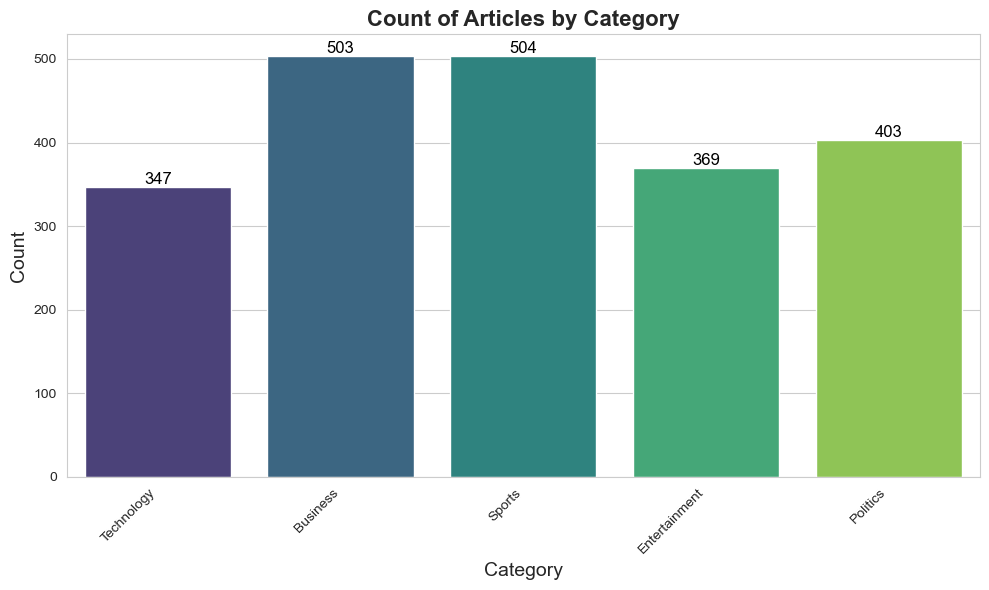

In [12]:
# Set figure size and style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create count plot with color palette and assign it to a variable
plot = sns.countplot(x='Category', data=df, palette='viridis')

# Add titles and labels
plt.title('Count of Articles by Category', fontsize=16, weight='bold')
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value annotations on each bar
for p in plot.patches:
    height = p.get_height()
    plot.annotate(f'{int(height)}', 
                  (p.get_x() + p.get_width() / 2, height), 
                  ha='center', va='bottom', 
                  fontsize=12, color='black')

# Show plot
plt.tight_layout()
plt.show()


In [13]:
df.to_csv('cleaned_data.csv', index=False)
df

,Category,Article
0,Technology,tv future in the hands of viewers with home th...
1,Business,worldcom boss left books alone former worldc...
2,Sports,tigers wary of farrell gamble leicester say ...
3,Sports,yeading face newcastle in fa cup premiership s...
4,Entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,Business,cars pull down us retail figures us retail sal...
2221,Politics,kilroy unveils immigration policy ex-chatshow ...
2222,Entertainment,rem announce new glasgow concert us band rem h...
2223,Politics,how political squabbles snowball it s become c...


### In order to clean the text data which is in English language, downloading necessary packages such as stopswords, punctuations, etc.

In [14]:
%%capture
nltk.download('punkt') # Download for tokenization
nltk.download('stopwords') # Download stopwords
nltk.download('wordnet') # Download for lemmatization

sns.set_style('white')
plt.rcParams['figure.figsize'] = (9, 9)
plt.rcParams['date.autoformatter.day'] = '%d-%b'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rajen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Preprocessing the text data

In [15]:
def preprocess_text(text):
    
    cleaned_text = clean_text(text) #Remove non-letter characters
    
    tokens = tokenize_text(cleaned_text) #Tokenize and lowercase
    
    tokens = remove_stopwords(tokens) # Remove stopwords
    
    lemmatized_tokens = lemmatize_tokens(tokens) #Lemmatize the tokens
    
    return ' '.join(lemmatized_tokens)

def clean_text(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def tokenize_text(text):
    return nltk.word_tokenize(text.lower())

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

#### Visualizing different words in sentenses just to get better idea

In [17]:
df['Processed_Articles'] = df['Article'].apply(preprocess_text)
df.head()

,Category,Article,Processed_Articles
0,Technology,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,Business,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...
2,Sports,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...
3,Sports,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...
4,Entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...


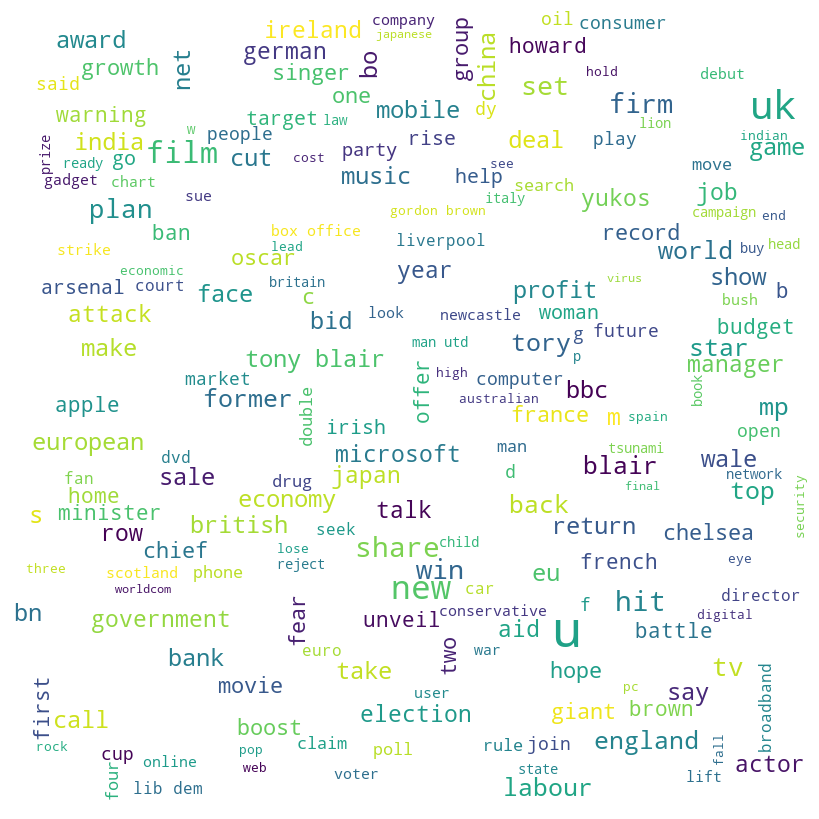

In [18]:
from wordcloud import WordCloud,STOPWORDS

wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = STOPWORDS ,
            max_font_size = 50,
            min_font_size = 10).generate(df['Processed_Articles'].to_string())
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [19]:
# most frequent words
def word_count(str):
    '''
    Function that get string and counts each word in the string
    '''
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        elif(len(word)>2):
            counts[word] = 1
    return counts

In [20]:
most_frequent_words = Counter(word_count(str(df['Processed_Articles'].to_string()))).most_common(100)
print('\n'.join(map(str, most_frequent_words)))
most_frequent_words = None
del(most_frequent_words)
gc.collect()

('...', 299)
('new', 92)
('blair', 82)
('film', 73)
('hit', 65)
('share', 60)
('win', 58)
('england', 55)
('world', 55)
('labour', 55)
('set', 55)
('star', 54)
('firm', 53)
('tory', 52)
('plan', 52)
('top', 51)
('mobile', 50)
('back', 44)
('former', 42)
('tony', 40)
('net', 40)
('game', 38)
('show', 37)
('economy', 37)
('take', 36)
('get', 36)
('face', 35)
('deal', 35)
('wale', 35)
('bank', 35)
('sale', 35)
('say', 34)
('india', 34)
('music', 34)
('china', 34)
('call', 32)
('award', 32)
('brown', 32)
('oil', 30)
('british', 30)
('european', 30)
('one', 29)
('s...', 29)
('man', 29)
('cut', 29)
('bid', 29)
('make', 29)
('bbc', 29)
('return', 28)
('could', 28)
('profit', 28)
('aid', 28)
('howard', 27)
('price', 27)
('talk', 26)
('election', 26)
('actor', 25)
('microsoft', 25)
('ireland', 25)
('year', 25)
('oscar', 25)
('bos', 24)
('row', 24)
('coach', 24)
('cup', 23)
('german', 23)
('job', 23)
('yukos', 23)
('apple', 23)
('attack', 23)
('japan', 22)
('government', 22)
('m...', 22)
('minis

2523

### Encoding the target variable

In [21]:
df['Category_Encoded'] = df['Category'].astype('category').cat.codes
df.head()

,Category,Article,Processed_Articles,Category_Encoded
0,Technology,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...,4
1,Business,worldcom boss left books alone former worldc...,worldcom bos left book alone former worldcom b...,0
2,Sports,tigers wary of farrell gamble leicester say ...,tiger wary farrell gamble leicester say rushed...,3
3,Sports,yeading face newcastle in fa cup premiership s...,yeading face newcastle fa cup premiership side...,3
4,Entertainment,ocean s twelve raids box office ocean s twelve...,ocean twelve raid box office ocean twelve crim...,1


## An option for the user to choose between Bag of Words and TF-IDF techniques for vectorizing the data

In [22]:
vectorization_method = input("Choose vectorization method (1 for Bag of Words, 2 for TF-IDF): ")

if vectorization_method == '1':
    vectorizer = CountVectorizer()
    print("Bag of Words Technique")
else:
    vectorizer = TfidfVectorizer()
    print("TF-IDF Technique")

Choose vectorization method (1 for Bag of Words, 2 for TF-IDF): 2
TF-IDF Technique


In [23]:
X = vectorizer.fit_transform(df['Processed_Articles'])
y = df['Category_Encoded']

Shape of X_train: (1594, 27175)
Shape of X_test: (532, 27175)
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       121
           1       0.98      0.94      0.96        98
           2       0.93      0.93      0.93       101
           3       0.98      1.00      0.99       132
           4       0.96      0.91      0.94        80

    accuracy                           0.95       532
   macro avg       0.95      0.95      0.95       532
weighted avg       0.95      0.95      0.95       532



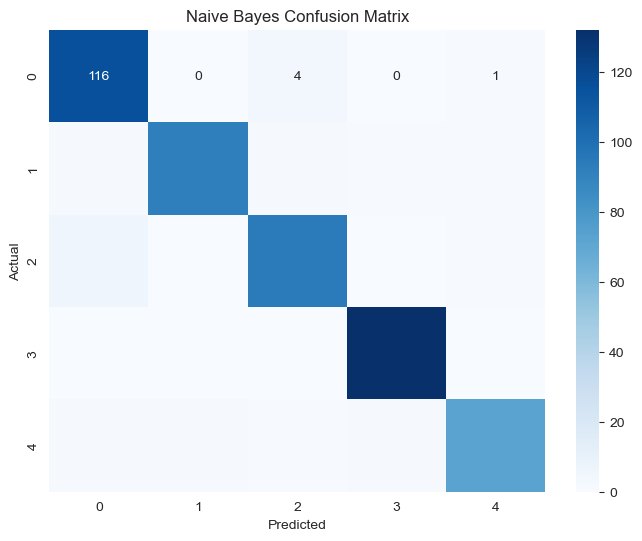

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       121
           1       0.92      0.81      0.86        98
           2       0.86      0.83      0.84       101
           3       0.90      0.95      0.92       132
           4       0.78      0.84      0.81        80

    accuracy                           0.86       532
   macro avg       0.86      0.85      0.86       532
weighted avg       0.86      0.86      0.86       532



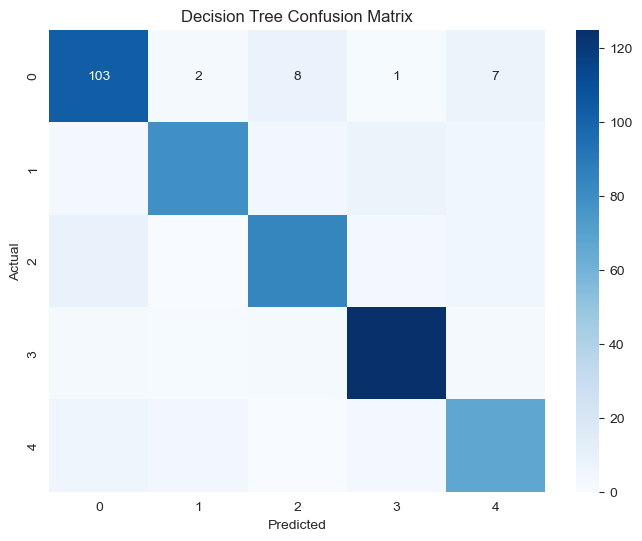

K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       121
           1       0.95      0.93      0.94        98
           2       0.87      0.94      0.90       101
           3       0.98      0.98      0.98       132
           4       0.91      0.93      0.92        80

    accuracy                           0.94       532
   macro avg       0.93      0.93      0.93       532
weighted avg       0.94      0.94      0.94       532



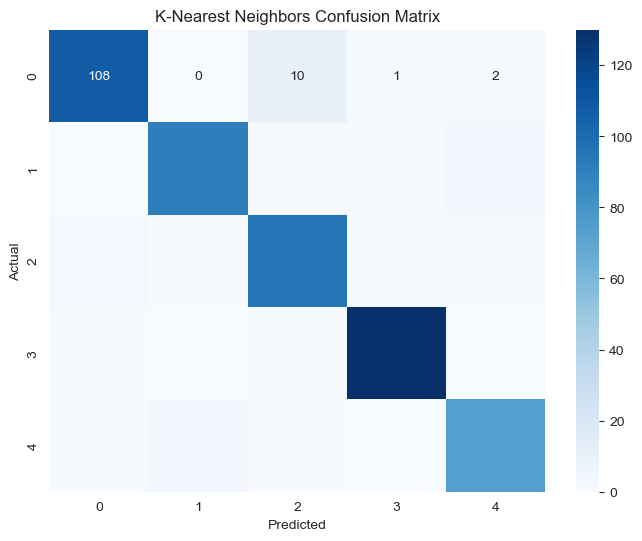

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       121
           1       0.98      0.96      0.97        98
           2       0.96      0.88      0.92       101
           3       0.96      1.00      0.98       132
           4       0.96      0.89      0.92        80

    accuracy                           0.95       532
   macro avg       0.95      0.94      0.94       532
weighted avg       0.95      0.95      0.95       532



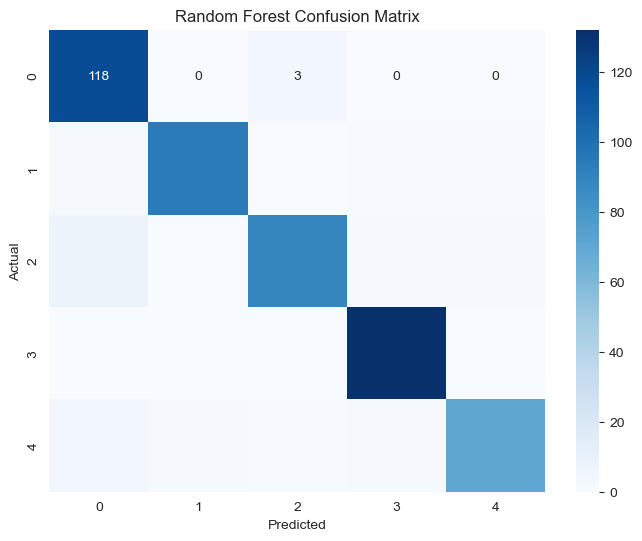

In [24]:
# Train-test split (75:25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Function to train and evaluate a model
def train_and_evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Training and evaluating models
models = {
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    train_and_evaluate_model(model, name)

### TF-IDF technique

In [25]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Processed_Articles'])
y = df['Category_Encoded']

In [26]:
# Train-test split (75:25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (1594, 27175)
Shape of X_test: (532, 27175)


In [27]:
print("News articles per category:\n", df['Category'].value_counts())

News articles per category:
 Category
Sports           504
Business         503
Politics         403
Entertainment    369
Technology       347
Name: count, dtype: int64


In [28]:
def train_and_evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       121
           1       0.98      0.94      0.96        98
           2       0.93      0.93      0.93       101
           3       0.98      1.00      0.99       132
           4       0.96      0.91      0.94        80

    accuracy                           0.95       532
   macro avg       0.95      0.95      0.95       532
weighted avg       0.95      0.95      0.95       532



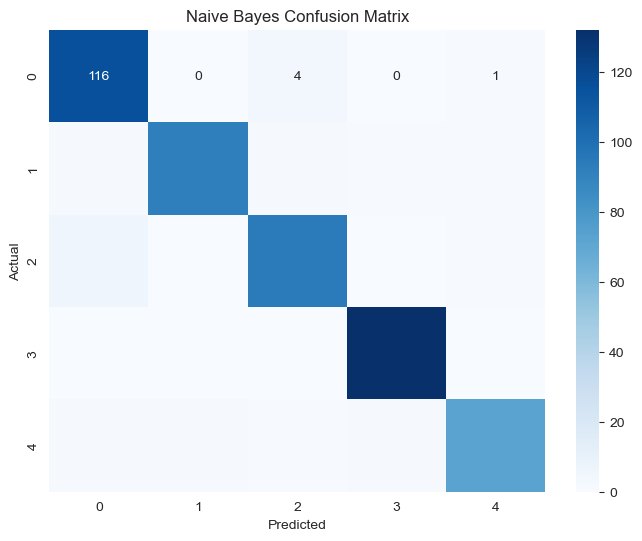

In [29]:
train_and_evaluate_model(MultinomialNB(), "Naive Bayes")

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85       121
           1       0.88      0.86      0.87        98
           2       0.88      0.81      0.85       101
           3       0.91      0.95      0.93       132
           4       0.76      0.82      0.79        80

    accuracy                           0.86       532
   macro avg       0.86      0.86      0.86       532
weighted avg       0.86      0.86      0.86       532



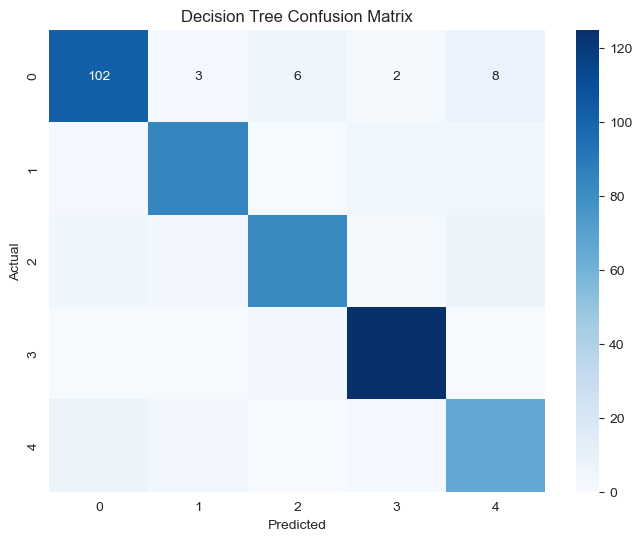

In [30]:
train_and_evaluate_model(DecisionTreeClassifier(), "Decision Tree")

K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       121
           1       0.95      0.93      0.94        98
           2       0.87      0.94      0.90       101
           3       0.98      0.98      0.98       132
           4       0.91      0.93      0.92        80

    accuracy                           0.94       532
   macro avg       0.93      0.93      0.93       532
weighted avg       0.94      0.94      0.94       532



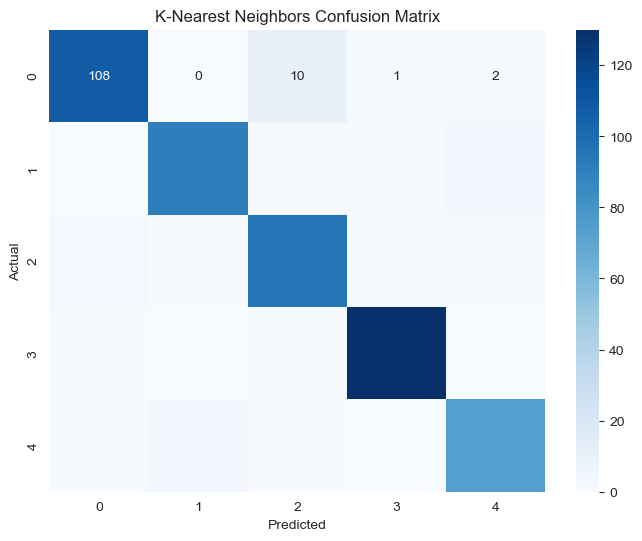

In [31]:
train_and_evaluate_model(KNeighborsClassifier(), "K-Nearest Neighbors")

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       121
           1       0.95      0.95      0.95        98
           2       0.94      0.88      0.91       101
           3       0.97      1.00      0.99       132
           4       0.97      0.89      0.93        80

    accuracy                           0.94       532
   macro avg       0.94      0.94      0.94       532
weighted avg       0.94      0.94      0.94       532



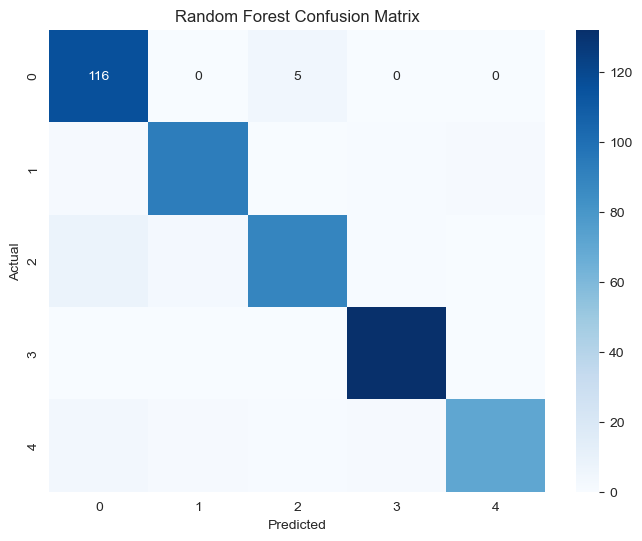

In [32]:
train_and_evaluate_model(RandomForestClassifier(), "Random Forest")

### Bag of Words Technique

In [33]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Processed_Articles'])
y = df['Category_Encoded']

In [34]:
# Train-test split (75:25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (1594, 27175)
Shape of X_test: (532, 27175)


In [35]:
def train_and_evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       121
           1       0.97      0.98      0.97        98
           2       0.95      0.97      0.96       101
           3       1.00      1.00      1.00       132
           4       0.95      0.95      0.95        80

    accuracy                           0.97       532
   macro avg       0.97      0.97      0.97       532
weighted avg       0.97      0.97      0.97       532



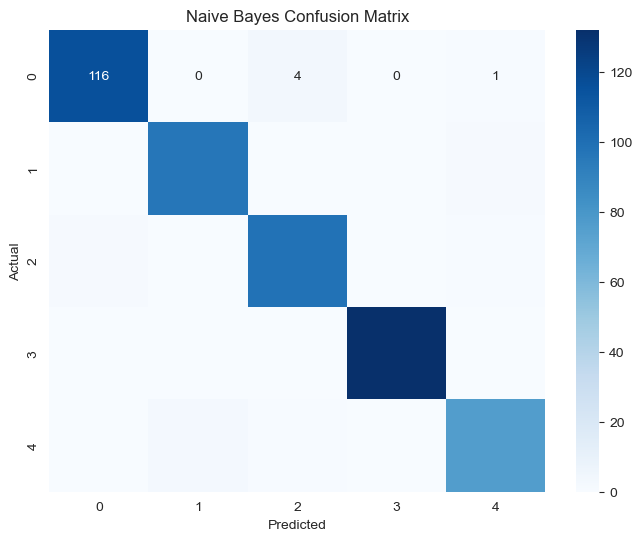

In [36]:
train_and_evaluate_model(MultinomialNB(), "Naive Bayes")

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       121
           1       0.88      0.80      0.83        98
           2       0.90      0.81      0.85       101
           3       0.89      0.96      0.92       132
           4       0.81      0.82      0.82        80

    accuracy                           0.86       532
   macro avg       0.86      0.85      0.85       532
weighted avg       0.86      0.86      0.85       532



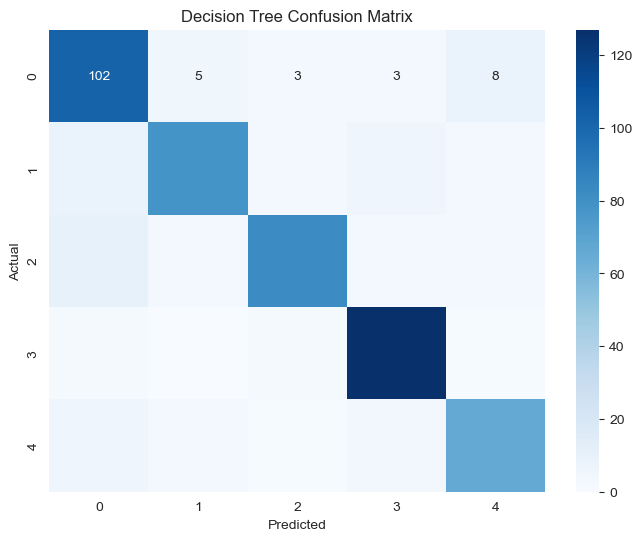

In [37]:
train_and_evaluate_model(DecisionTreeClassifier(), "Decision Tree")

K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.61      0.73       121
           1       0.83      0.61      0.71        98
           2       0.89      0.71      0.79       101
           3       0.50      1.00      0.67       132
           4       1.00      0.42      0.60        80

    accuracy                           0.70       532
   macro avg       0.83      0.67      0.70       532
weighted avg       0.80      0.70      0.70       532



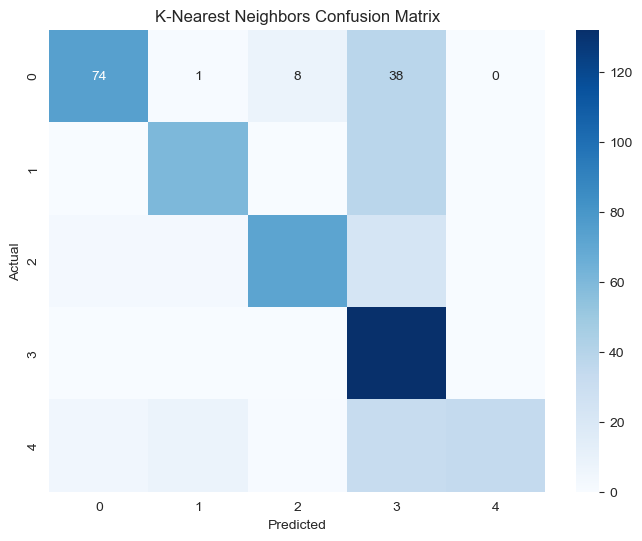

In [38]:
train_and_evaluate_model(KNeighborsClassifier(), "K-Nearest Neighbors")

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.92       121
           1       0.98      0.96      0.97        98
           2       0.94      0.87      0.90       101
           3       0.96      1.00      0.98       132
           4       0.97      0.90      0.94        80

    accuracy                           0.94       532
   macro avg       0.95      0.94      0.94       532
weighted avg       0.94      0.94      0.94       532



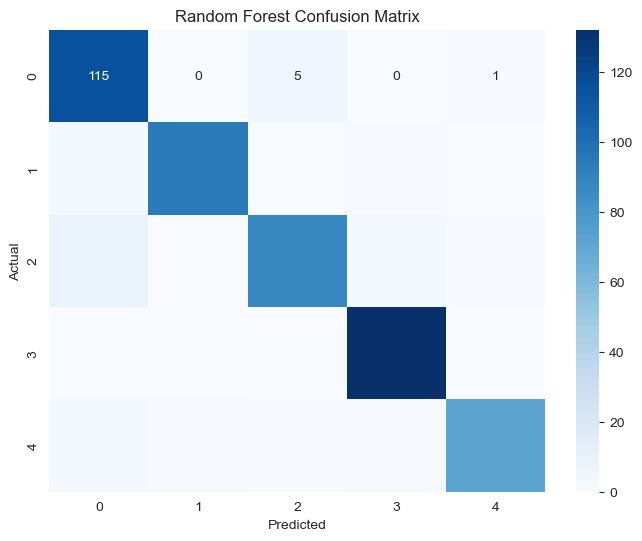

In [39]:
train_and_evaluate_model(RandomForestClassifier(), "Random Forest")

## Questionnaire:

1. How many news articles are present in the dataset that we have? 
##### Ans. - 2126 unique articles


2. Most of the news articles are from _____ category.
##### Ans. - Sports 

3. Only ___ no. of articles belong to the ‘Technology’ category.
##### Ans. -  347

4. What are Stop Words and why should they be removed from the text data?
##### Ans. -  Stop Words are common words (such as "and", "the", "is") that are often filtered out in natural language processing because they carry little meaningful information and can add noise to text analysis.

5. Explain the difference between Stemming and Lemmatization.
##### Ans. -  Stemming reduces words to their root form, often resulting in non-words (e.g., "running" becomes "run"). In contrast, Lemmatization considers the context and converts a word to its base or dictionary form (e.g., "better" becomes "good"). Lemmatization is generally more accurate but computationally more intensive than stemming.

6. Which of the techniques Bag of Words or TF-IDF is considered to be more efficient than the other?
##### Ans. -  TF-IDF (Term Frequency-Inverse Document Frequency) is often considered more efficient than Bag of Words because it not only counts word occurrences but also weighs them according to their importance across documents, helping to reduce the impact of common words that appear frequently in many documents.

7. What’s the shape of train & test data sets after performing a 75:25 split.
##### Ans. -  Shape of Train Data  : (1594, 27175) & Shape of Test Data: (532, 27175)

8. Which of the following is found to be the best performing model..
a. Random Forest b. Nearest Neighbors c. Naive Bayes
##### Ans. -  Naive Bayes - Its a combination of simplicity, efficiency, robustness to irrelevant features, and surprisingly strong performance in text classification tasks contributes to its reputation as a top-performing model in scenarios involving categorical data like news articles.

9. According to this particular use case, both precision and recall are equally important. (T/F)
##### Ans. -  True